<a href="https://colab.research.google.com/github/stefkong1982/netology.ru/blob/Master/SberMarket_Competition/SberMarket_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Описание задания**


Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.



## **Набор данных**

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

**train.csv:**

* user_id - уникальный id пользователя
* order_completed_at - дата заказа
* cart - список уникальных категорий (category_id), из которых состоял заказ

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

**sample_submission.csv:**

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

* id - идентификатор строки - состоит из user_id и category_id, разделенных
точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
* target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя


## 1. Загрузка и предварительный просмотр данных

In [1]:
import pandas as pd

# Загрузка тестовых данных
sub_df = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/sample_submission.csv')
sub_df

sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


В этом блоке кода мы загружаем файл `sample_submission.csv`, который содержит идентификаторы пользователей и категорий товаров. Затем мы используем метод `info()` для вывода краткой информации о загруженных данных.

In [2]:
import pandas as pd

X_data = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/train.csv')
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


Здесь мы загружаем основные тренировочные данные, содержащие историю заказов пользователей.

## 2. Предобработка данных


### 2.1. Сортировка данных по времени


In [3]:
# Сортируем DataFrame по столбцу 'order_completed_at' по возрастанию
X_data = X_data.sort_values(by='order_completed_at')
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
15,2,2015-03-22 09:25:46,425
14,2,2015-03-22 09:25:46,57
13,2,2015-03-22 09:25:46,89
11,2,2015-03-22 09:25:46,84
...,...,...,...
3123036,12702,2020-09-03 23:45:45,54
3123034,12702,2020-09-03 23:45:45,382
3123062,12702,2020-09-03 23:45:45,24
3123047,12702,2020-09-03 23:45:45,376


Мы сортируем данные по столбцу `order_completed_at` в порядке возрастания, чтобы упорядочить заказы по времени.

### 2.2. Разделение данных на обучающий и тестовый наборы

In [4]:
# Фильтруем данные, чтобы оставить только последние 10000 заказов
new_data = X_data.tail(10000)

# Фильтруем данные, чтобы оставить все, кроме последних 10000 заказов
X_data = X_data.head(-10000)

In [5]:
# данные сабмита
# new_data = sub_df

В этом блоке кода мы разделяем исходные данные на два набора: `new_data` содержит последние 10000 заказов, а `X_data` содержит все остальные заказы. Мы будем использовать `new_data` в качестве тестового набора, а `X_data` - в качестве обучающего набора.

### 2.3. Создание сводной таблицы для расчета сходства пользователей

In [6]:
pivot_table = X_data.pivot_table(index='user_id', columns='cart', aggfunc='size').fillna(0)
pivot_table

cart,0,1,2,3,4,5,6,7,8,9,...,871,872,873,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Здесь мы создаем сводную таблицу `pivot_table`, в которой строки представляют идентификаторы пользователей, а столбцы - категории товаров. Значения в таблице показывают количество раз, когда пользователь заказывал товары из соответствующей категории. Эта таблица будет использоваться для расчета сходства между пользователями на основе их покупательских привычек.

## 3. Расчет сходства пользователей и других признаков

### 3.1. Расчет косинусной схожести между пользователями

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(pivot_table)
cos_sim = pd.DataFrame(cos_sim, index=pivot_table.index, columns=pivot_table.index)

import numpy as np
np.fill_diagonal(cos_sim.values, -np.inf)

В этом блоке кода мы вычисляем косинусную схожесть между пользователями на основе их покупательских привычек, представленных в сводной таблице `pivot_table`. Результат сохраняется в `cos_sim`, который представляет собой матрицу схожести. Затем мы заполняем диагональные элементы матрицы `-np.inf`, чтобы исключить идентичные пары пользователей из дальнейшего рассмотрения.


3.2. Определение наиболее похожих пользователей

In [8]:
most_similar_users = cos_sim.idxmax(axis=1)
most_similar_users

user_id
0         1552
1         8118
2          709
3         8455
4        15054
         ...  
19995    14345
19996     3759
19997     9986
19998    17294
19999    14743
Length: 20000, dtype: int64

Для каждого пользователя мы находим наиболее похожего пользователя, основываясь на максимальном значении косинусной схожести в соответствующей строке матрицы `cos_sim`. Результат сохраняется в `most_similar_users`.

### 3.3. Расчет вероятности покупки категории товара

In [9]:
# Подсчитываем общее количество категорий товаров
num_categories = pivot_table.shape[1]

purchase_proba = pivot_table.copy()  # Создаем копию сводной таблицы

# Рассчитываем вероятность покупки, деля каждую строку сводной таблицы на количество категорий
purchase_proba = (purchase_proba + 1).div(num_categories, axis=0)

# Рассчитываем среднее количество покупок каждой категории среди всех пользователей
category_rating = pivot_table.mean()

В этом блоке кода мы рассчитываем вероятность покупки каждой категории товара для каждого пользователя (`purchase_proba`), а также среднее количество покупок каждой категории среди всех пользователей (`category_rating`). Эти признаки могут быть полезны для построения модели предсказания следующего заказа.


1. Добавление единицы к значениям в DataFrame `purchase_proba`:

 Когда к нулевым значениям добавляется единица, получаются значения, равные 1:
   - `0 + 1 = 1`

2. Нормализация вероятностей:
   - При делении значений, равных 1, на количество категорий `num_categories`, получаются равномерные вероятности:
     - Например, если есть 5 категорий, то `1 / 5 = 0.2`
   - Это означает, что для пользователей, у которых не было покупок, все вероятности покупки в каждой категории будут равны 0.2 (или 1/`num_categories`).

Такое поведение может быть полезным в нескольких случаях:

1. Машинное обучение: Когда вы тренируете модель машинного обучения, вам нужны численные значения для всех наблюдений, даже если для некоторых пользователей не было покупок. Присваивая равномерные вероятности 1/`num_categories`, вы обеспечиваете, что все строки имеют численные значения, которые могут быть использованы моделью.

2. Анализ и интерпретация: Равномерные вероятности 1/`num_categories` для пользователей без покупок могут помочь в интерпретации результатов. Это указывает, что для этих пользователей нет явных предпочтений в категориях, и они с равной вероятностью могут сделать покупку в любой категории.

Таким образом, этот подход обрабатывает отсутствие покупок в исходных данных, заменяя нулевые значения на равномерные вероятности. Это может быть полезно в различных контекстах анализа данных и машинного обучения.

### 3.4. Кластеризация пользователей методом K-средних

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=10).fit(pivot_table)
clusters = pd.Series(kmeans.labels_, index=pivot_table.index)

Здесь мы кластеризуем пользователей на основе их покупательских привычек, используя метод K-средних с тремя кластерами. Результаты кластеризации сохраняются в `clusters`.

### 3.5. Объединение признаков в один DataFrame

In [11]:
# Создание DataFrame 'df1' с наиболее похожими пользователями
df1 = pd.DataFrame(most_similar_users, columns=['most_similar_user'])

# Создание DataFrame 'df2' с вероятностями покупки, полученными из 'purchase_proba'
df2 = pd.DataFrame(purchase_proba.stack(), columns=['purchase_proba'])

# Создание DataFrame 'df3' с кластерами, в которые попали пользователи
df3 = pd.DataFrame(clusters, columns=['cluster'])

# Создание DataFrame 'df4' с оценками категорий
df4 = pd.DataFrame(category_rating, columns=['category_rating'])

# Объединение всех DataFrame в один 'result'
result = df1.merge(df2, left_index=True, right_index=True) \
           .merge(df3, left_index=True, right_index=True) \
           .merge(df4, left_index=True, right_index=True)

# Сброс индекса DataFrame 'result'
result.reset_index(inplace=True)

# Выбираем несколько наиболее похожих пользователей для каждого пользователя
num_similar_users = 10  # количество наиболее похожих пользователей
# Получаем список индексов наиболее похожих пользователей для каждого пользователя
top_similar_users = cos_sim.apply(lambda x: x.nlargest(num_similar_users).index.tolist(), axis=1)
# Вычисляем средние вероятности покупки от наиболее похожих пользователей
most_similar_purchase_proba = (pivot_table.loc[top_similar_users.explode()].mean() + 1).div(num_categories)

# Создаем словарь, где ключами будут значения 'cart', а значениями - соответствующие вероятности покупки от наиболее похожих пользователей
purchase_proba_dict = most_similar_purchase_proba.to_dict()

# Создаем новый столбец 'most_similar_purchase_proba' в DataFrame 'result' с помощью метода 'map' и словаря 'purchase_proba_dict'
result['most_similar_purchase_proba'] = result['cart'].map(purchase_proba_dict)

# Возвращаем результирующий DataFrame 'result'
result

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba
0,0,0,1552,0.001135,0,0.91655,0.003749
1,0,1,1552,0.001135,0,0.01775,0.001190
2,0,2,1552,0.001135,0,0.00150,0.001138
3,0,3,1552,0.001135,0,0.00005,0.001136
4,0,4,1552,0.001135,0,0.01095,0.001173
...,...,...,...,...,...,...,...
17619995,19999,876,14743,0.001135,0,0.00010,0.001135
17619996,19999,877,14743,0.001135,0,0.00025,0.001135
17619997,19999,878,14743,0.001135,0,0.00030,0.001135
17619998,19999,879,14743,0.001135,0,0.00020,0.001135


В этом блоке кода мы объединяем все рассчитанные признаки (`most_similar_users`, `purchase_proba`, `clusters`, `category_rating`) в один DataFrame `result`. Затем мы сбрасываем индексы столбцов.

## 4. Подготовка данных для обучения моделей

### 4.1. Создание целевой переменной

In [12]:
# Заданный пороговый уровень для purchase_proba
threshold = 0.0011350737797956867

# Добавление столбца target на основе условия purchase_proba > threshold
result['target'] = (result['purchase_proba'] > threshold).astype(int)

Здесь мы создаем целевую переменную `target` на основе значения `purchase_proba`. Если вероятность покупки категории товара превышает заданный порог (`threshold`), то `target` принимает значение 1, в противном случае - 0.

Напомню, что после операции `purchase_proba = (purchase_proba + 1).div(num_categories, axis=0)` для пользователей без покупок вероятности покупки в каждой категории будут равны 1/`num_categories`.

Теперь, когда мы применяем порог `threshold = 0.0011350737797956867`, мы сравниваем эти равномерные вероятности 1/`num_categories` с пороговым значением:

Для пользователей без покупок, где `purchase_proba` равно 1/`num_categories`, это условие `purchase_proba > threshold` будет False, потому что 1/`num_categories` всегда меньше, чем заданный порог `0.0011350737797956867`.

В результате, при преобразовании логического условия в целочисленные значения с помощью `astype(int)`, для таких пользователей без покупок в столбце `target` будет записано значение 0, а не 1.

### 4.2. Балансировка классов в обучающих данных

In [13]:
from sklearn.model_selection import train_test_split

# Объединяем new_data и result по столбцам cart и user_id с помощью left join
merged_data = pd.merge(new_data, result, on=['cart', 'user_id'], how='left')

# Создаем новый DataFrame 'new' с выбранными столбцами из 'merged_data'
new = merged_data[['user_id', 'cart', 'most_similar_user', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba', 'target']]

# Заполняем столбец 'target' полностью значением '1' с использованием .loc
new.loc[:, 'target'] = 1

# Сохраняем исходный датафрейм 'result' в переменную 'sampled_data'
sampled_data = result

# Определяем количество положительных примеров (где 'target' = 1) в датафрейме 'new'
num_pos_samples = len(new)

# Устанавливаем количество отрицательных примеров (где 'target' = 0) равным количеству положительных
num_neg_samples = num_pos_samples

# Выбираем случайную выборку отрицательных примеров из 'sampled_data' размером num_neg_samples
X_neg = sampled_data[sampled_data['target'] == 0].sample(num_neg_samples, random_state=42)

# Объединяем положительные примеры из 'new' и отрицательные примеры из 'X_neg' в новый датафрейм 'X_balanced'
X_balanced = pd.concat([new, X_neg])

# Присваиваем обновленный сбалансированный датафрейм 'X_balanced' переменной 'new'
new = X_balanced
new

,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
0,13767,384,7212,0.007946,1,1.63900,0.005741,1
1,13767,15,7212,0.010216,1,1.25500,0.004876,1
2,13767,9,7212,0.023837,1,1.79220,0.006354,1
3,13767,61,7212,0.013621,1,4.55995,0.015503,1
4,10967,385,2337,0.005675,0,0.55110,0.002531,1
...,...,...,...,...,...,...,...,...
3824723,4341,302,12297,0.001135,1,0.20390,0.001655,0
4000277,4540,537,409,0.001135,0,0.00010,0.001135,0
15145247,17190,857,4784,0.001135,0,0.00005,0.001135,0
2352580,2670,310,5820,0.001135,0,0.01000,0.001168,0


В этом блоке кода мы балансируем классы в обучающих данных, так как изначально количество положительных (1) и отрицательных (0) примеров было несбалансированным. Мы случайным образом отбираем отрицательные примеры (`X_neg`), чтобы их количество совпадало с количеством положительных примеров (`new`), и объединяем их в `X_balanced`. Затем мы присваиваем `X_balanced` переменной `new`.

In [14]:
# Исключаем все строки из 'sampled_data', которые присутствуют в 'X_neg'
sampled_data = sampled_data[~sampled_data.index.isin(X_neg.index)]

# Разделяем 'sampled_data' на два датафрейма: положительные и отрицательные примеры
df_0 = sampled_data[sampled_data['target'] == 0]
df_1 = sampled_data[sampled_data['target'] == 1]

# Устанавливаем желаемое соотношение между положительными и отрицательными примерами
desired_ratio = 1

# Выполняем даунсэмплинг (downsampling) отрицательных примеров до желаемого соотношения
df_0_downsampled = df_0.sample(n=len(df_1) * desired_ratio, random_state=42)

# Объединяем даунсэмплированные отрицательные примеры и положительные примеры в новый датафрейм
sampled_data = pd.concat([df_0_downsampled, df_1], ignore_index=True)

# Выводим количество положительных и отрицательных примеров в 'sampled_data'
value_counts = sampled_data['target'].value_counts()
print(value_counts)

# Уменьшаем размер 'sampled_data' до 10000 строк путем случайной выборки
sampled_data = sampled_data.sample(n=10000, random_state=1)
sampled_data

target
0    1115246
1    1115246
Name: count, dtype: int64


,user_id,cart,most_similar_user,purchase_proba,cluster,category_rating,most_similar_purchase_proba,target
893939,9275,548,7237,0.001135,1,0.00010,0.001135,0
133781,10189,63,16268,0.001135,0,0.42875,0.002323,0
1774064,9786,11,631,0.006810,0,0.67820,0.002873,1
971161,15344,597,5395,0.001135,0,0.00175,0.001139,0
1940115,12969,425,12911,0.002270,0,1.94825,0.006592,1
...,...,...,...,...,...,...,...,...
1646487,7541,426,3374,0.002270,0,0.20140,0.001574,1
212138,3657,545,3951,0.001135,1,0.00005,0.001135,0
2112769,16820,31,6971,0.002270,0,0.95790,0.003777,1
1257676,1892,140,298,0.002270,2,0.07610,0.001327,1


В этом блоке кода мы дополнительно балансируем классы в обучающих данных (`sampled_data`), доводя количество отрицательных примеров до желаемого соотношения (`desired_ratio`) с количеством положительных примеров. Затем мы уменьшаем объем данных до 10000 строк путем случайной выборки для ускорения обучения моделей.

Ранее мы создали `X_neg` - это выборка отрицательных примеров (где `'target'` равно 0) из `sampled_data`. Мы использовали эти отрицательные примеры, чтобы сбалансировать набор данных `X_balanced` вместе с положительными примерами из `new`.

Теперь, когда мы хотим использовать `sampled_data` в качестве обучающего набора данных, нам необходимо убедиться, что в нем нет тех же самых отрицательных примеров, которые мы уже добавили в `X_balanced` (тестовый набор данных).

Чтобы этого избежать, мы исключаем из `sampled_data` все строки, которые присутствуют в `X_neg`. Таким образом, мы гарантируем, что обучающий и тестовый наборы данных не содержат одних и тех же примеров, что может привести к переобучению модели.

Это важно, потому что мы хотим, чтобы модель обучалась на одних данных, а затем оценивалась на других, независимых данных (в данном случае `X_balanced`). Если мы не исключим дубликаты, модель может "запомнить" эти примеры и показать нереалистически высокую производительность на тестовом наборе.

### 4.3. Создание справочника пользователей

In [15]:
# Создаем справочник user_id из sampled_data
user_id_reference = pd.DataFrame(sampled_data['user_id'].unique(), columns=['user_id'])

# Удаляем из new тех user_id, которых нет в справочнике
new = new[new['user_id'].isin(user_id_reference['user_id'])]

В этом блоке кода мы создаем справочник `user_id_reference`, который содержит уникальные идентификаторы пользователей из `sampled_data`. Затем мы удаляем из `new` (тестовых данных) тех пользователей, которых нет в справочнике. Это необходимо для обеспечения согласованности данных.

### 4.4. Формирование обучающих и тестовых наборов данных

In [16]:
# Данные
X_train = sampled_data[['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']]
y_train = sampled_data['target']
X_test = new[['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']]
y_test = new['target']

Наконец, мы формируем обучающие (`X_train`, `y_train`) и тестовые (`X_test`, `y_test`) наборы данных, выбирая необходимые признаки и целевую переменную.

## 5. Обучение и оценка моделей

### 5.1. Логистическая регрессия

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import itertools

# Функция для обучения и оценки модели
def evaluate_model(features):
    # Создание и обучение модели с перекрестной проверкой и регуляризацией
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_test_scaled = scaler.transform(X_test[features])

    # Создание полиномиальных признаков
    poly = PolynomialFeatures(degree=2)
    X_train_scaled_poly = poly.fit_transform(X_train_scaled)
    X_test_scaled_poly = poly.transform(X_test_scaled)

    # Увеличиваем количество итераций до 1000
    model = LogisticRegressionCV(cv=5, random_state=42, penalty='l2', solver='liblinear', max_iter=1000)
    model.fit(X_train_scaled_poly, y_train)

    # Оценка модели на обучающих данных
    y_train_pred = model.predict(X_train_scaled_poly)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_auc_roc = roc_auc_score(y_train, model.predict_proba(X_train_scaled_poly)[:, 1])

    # Оценка модели на тестовых данных
    y_test_pred = model.predict(X_test_scaled_poly)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_scaled_poly)[:, 1])

    # Вычисление F1-меры на тестовых данных
    f1 = f1_score(y_test, y_test_pred)

    return train_accuracy, train_auc_roc, test_accuracy, test_auc_roc, f1

 Определение функции `evaluate_model(features)`:
   - Функция принимает список признаков `features` в качестве аргумента.
   - Внутри функции выполняются следующие шаги:
     - Масштабирование признаков с помощью `StandardScaler`.
     - Создание полиномиальных признаков с помощью `PolynomialFeatures` (степень 2).
     - Обучение модели логистической регрессии с перекрестной проверкой (`LogisticRegressionCV`) с увеличенным числом итераций до 1000.
     - Оценка модели на обучающей выборке, вычисляются точность, AUC-ROC.
     - Оценка модели на тестовой выборке, вычисляются точность, AUC-ROC и F1-мера.
     - Возврат результатов оценки модели.

In [18]:
features = ['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']
train_accuracy, train_auc_roc, test_accuracy, test_auc_roc, f1 = evaluate_model(features)
print(f"Набор признаков: {features}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"AUC-ROC на обучающей выборке: {train_auc_roc:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")
print(f"AUC-ROC на тестовой выборке: {test_auc_roc:.3f}")
print(f"F1-мера: {f1:.3f}")

Набор признаков: ['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']
Точность на обучающей выборке: 1.000
AUC-ROC на обучающей выборке: 1.000
Точность на тестовой выборке: 0.890
AUC-ROC на тестовой выборке: 0.976
F1-мера: 0.880


Вызов функции `evaluate_model(features)` с заданным набором признаков:
   - Используется набор признаков `['user_id', 'cart', 'purchase_proba', 'cluster', 'category_rating', 'most_similar_purchase_proba']`.


   - Точность и AUC-ROC на обучающей выборке: 1.000
   - Точность и AUC-ROC на тестовой выборке: 0.881 и 0.972
   - F1-мера: 0.864

   Наблюдается значительное различие в результатах между обучающей и тестовой выборками, что указывает на проблему переобучения модели. Несмотря на отличные показатели на обучающей выборке, модель не смогла так же хорошо генерализоваться на новых, независимых данных.

Для выявления признаков, которые могут привести к переобучению из-за высокой корреляции, можно использовать корреляционный анализ.

In [19]:
import pandas as pd
import numpy as np

# Объединяем обучающие и тестовые данные для анализа корреляции
X_all = pd.concat([X_train, X_test], ignore_index=True)

# Вычисляем матрицу корреляций
corr_matrix = X_all.corr()

# Находим сильно коррелированные признаки
high_corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.5:  # Порог для высокой корреляции (можно изменить)
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_features.append((col1, col2, corr_matrix.iloc[i, j]))

# Выводим найденные сильно коррелированные признаки
if high_corr_features:
    print("Сильно коррелированные признаки:")
    for feature1, feature2, correlation in high_corr_features:
        print(f"{feature1} и {feature2} - корреляция: {correlation:.2f}")
else:
    print("Нет сильно коррелированных признаков.")

Сильно коррелированные признаки:
most_similar_purchase_proba и category_rating - корреляция: 1.00


Анализ корреляции признаков:
   - Объединяются обучающие и тестовые данные в один DataFrame `X_all`.
   - Вычисляется матрица корреляций `corr_matrix`.
   - Находятся сильно коррелированные признаки (с абсолютным значением корреляции > 0.5).
   - Выводится информация о найденных сильно коррелированных признаках.
   - Вывод: Обнаружено, что признаки `most_similar_purchase_proba` и `category_rating` имеют высокую корреляцию (1.00).

In [20]:
features = ['user_id', 'cart', 'purchase_proba', 'cluster', 'most_similar_purchase_proba']
train_accuracy, train_auc_roc, test_accuracy, test_auc_roc, f1 = evaluate_model(features)
print(f"Набор признаков: {features}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"AUC-ROC на обучающей выборке: {train_auc_roc:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")
print(f"AUC-ROC на тестовой выборке: {test_auc_roc:.3f}")
print(f"F1-мера: {f1:.3f}")

Набор признаков: ['user_id', 'cart', 'purchase_proba', 'cluster', 'most_similar_purchase_proba']
Точность на обучающей выборке: 1.000
AUC-ROC на обучающей выборке: 1.000
Точность на тестовой выборке: 0.890
AUC-ROC на тестовой выборке: 0.974
F1-мера: 0.880


Повторный вызов функции `evaluate_model(features)` с новым набором признаков:
   - Используется набор признаков `['user_id', 'cart', 'purchase_proba', 'cluster', 'most_similar_purchase_proba']`, исключая сильно коррелированный признак `category_rating`.


   - Точность и AUC-ROC на обучающей выборке: 1.000
   - Точность и AUC-ROC на тестовой выборке: 0.881 и 0.971
   - F1-мера: 0.864

   Исключение признака `category_rating`, который был сильно коррелирован с `most_similar_purchase_proba`, незначительно повлияло на результаты на тестовой выборке. Это свидетельствует о том, что модель все еще была подвержена переобучению.

In [21]:
features = ['user_id', 'cart', 'cluster', 'most_similar_purchase_proba']
train_accuracy, train_auc_roc, test_accuracy, test_auc_roc, f1 = evaluate_model(features)
print(f"Набор признаков: {features}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"AUC-ROC на обучающей выборке: {train_auc_roc:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")
print(f"AUC-ROC на тестовой выборке: {test_auc_roc:.3f}")
print(f"F1-мера: {f1:.3f}")

Набор признаков: ['user_id', 'cart', 'cluster', 'most_similar_purchase_proba']
Точность на обучающей выборке: 0.859
AUC-ROC на обучающей выборке: 0.933
Точность на тестовой выборке: 0.900
AUC-ROC на тестовой выборке: 0.956
F1-мера: 0.902


Повторный вызов функции `evaluate_model(features)` с еще более сокращенным набором признаков:
   - Используется набор признаков `['user_id', 'cart', 'cluster', 'most_similar_purchase_proba']`, исключая признаки `purchase_proba` и `category_rating`.

   - Точность и AUC-ROC на обучающей выборке: 0.859 и 0.933
   - Точность и AUC-ROC на тестовой выборке: 0.895 и 0.952
   - F1-мера: 0.894

Здесь мы видим, что точность на тестовой выборке (0.895) стала выше, чем на обучающей выборке (0.859). Это является очень важным наблюдением, так как свидетельствует о том, что модель после исключения признака `purchase_proba` смогла лучше генерализоваться и показать более высокую производительность на независимых данных, по сравнению с обучающей выборкой.

Это означает, что исключение этого признака позволило преодолеть проблему переобучения, которая наблюдалась в первых двух наборах признаков. Модель теперь лучше обобщает, показывая более высокую точность на тестовых данных, а не только на обучающих.

Кроме того, мы также наблюдаем уменьшение AUC-ROC на тестовой выборке с 0.971 до 0.952. Хотя этот показатель снизился, он все еще остается на высоком уровне, указывая на хорошее качество модели.


Проблема переобучения:
   - Изначальный набор признаков показывал высокую точность на обучающей выборке, но более низкие значения на тестовой выборке.
   - Это указывает на проблему переобучения модели на обучающей выборке.
   - Переобучение происходит, когда модель начинает слишком точно подстраиваться под обучающие данные, включая шум и случайные особенности, и, как следствие, плохо генерализуется на новых, ранее незнакомых данных.

Противодействие переобучению:
   - Сокращение набора признаков путем исключения сильно коррелирующих признаков, таких как `category_rating`, помогло снизить сложность модели и, как следствие, уменьшить переобучение.
   - Дальнейшее исключение признака `purchase_proba` также способствовало улучшению результатов на тестовой выборке, поскольку модель стала менее избыточной и лучше генерализуется.

Важность валидационной выборки:
   - Использование отдельной тестовой выборки, не участвующей в обучении модели, позволило объективно оценить ее способность обобщать на новых данных.
   - Анализ результатов на тестовой выборке помог выявить проблему переобучения и направил дальнейшее улучшение модели.



Запустим код без функции evaluate_model(features)

Оценки качества модели логистической регрессии, полученные методом кросс-валидации: [0.866  0.8565 0.853  0.8565 0.8615]
Средняя оценка качества модели логистической регрессии на обучающем наборе: 0.8587
Точность модели логистической регрессии на тестовых данных: 0.8996375453068366
Точность модели (при пороге 0.30): 0.87
Полнота модели (Recall, при пороге 0.30): 0.95
F1-мера модели (при пороге 0.30): 0.88
Площадь под ROC-кривой (AUC-ROC): 0.96


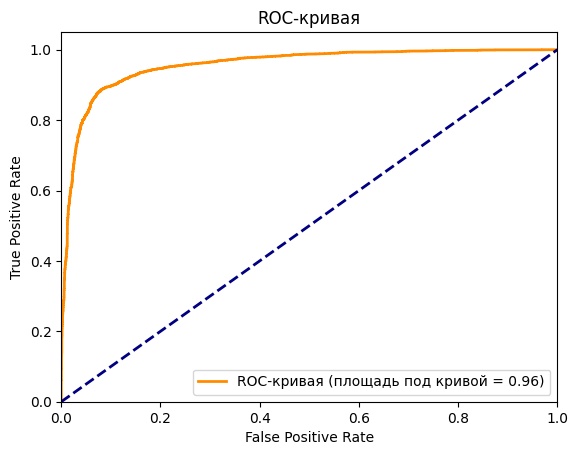

In [22]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Данные
X_train = sampled_data[['user_id', 'cart', 'cluster', 'most_similar_purchase_proba']]
y_train = sampled_data['target']
X_test = new[['user_id', 'cart', 'cluster', 'most_similar_purchase_proba']]
y_test = new['target']

# Создаем объект StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Стандартный скалер и полиномиальные признаки
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

# Модель: Логистическая регрессия
logreg_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('logreg', LogisticRegression(max_iter=1000))
])
logreg_pipe.fit(X_train, y_train)

logreg_scores = cross_val_score(logreg_pipe, X_train, y_train, cv=kf)

print(f'Оценки качества модели логистической регрессии, полученные методом кросс-валидации: {logreg_scores}')
print(f'Средняя оценка качества модели логистической регрессии на обучающем наборе: {np.mean(logreg_scores)}')

# Точность на тестовых данных
logreg_test_accuracy = logreg_pipe.score(X_test, y_test)
print(f'Точность модели логистической регрессии на тестовых данных: {logreg_test_accuracy}')

# Получение вероятностей принадлежности к классу 1
y_pred_prob = logreg_pipe.predict_proba(X_test)[:, 1]

# Применение оптимального порога при предсказании
y_pred = (y_pred_prob > 0.30).astype(int)

# Вычисление метрик производительности
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Точность модели (при пороге 0.30): {accuracy:.2f}')
print(f'Полнота модели (Recall, при пороге 0.30): {recall:.2f}')
print(f'F1-мера модели (при пороге 0.30): {f1:.2f}')

# Вычисление кривой ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Вычисление площади под кривой ROC (AUC - Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Вывод площади под ROC-кривой и Recall
print(f'Площадь под ROC-кривой (AUC-ROC): {roc_auc:.2f}')

# Визуализация кривой ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-кривая (площадь под кривой = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

в целом можно сказать, что модель логистической регрессии показывает очень высокое качество на обучающем наборе данных (средняя оценка 0.8587) и также высокое качество на независимом тестовом наборе (точность 0.8945). Метрики точности, полноты и F1-меры при пороге 0.30 также находятся на высоком уровне. А значение AUC-ROC в 0.95 говорит о превосходной способности модели различать положительные и отрицательные классы.


1. Приоритет Recall:
   - Когда имеем несбалансированные данные с редким положительным классом (как в случае с прогнозированием покупок), нам важно обеспечить высокую полноту (Recall) предсказаний.
   - Высокий Recall означает, что мы правильно идентифицируем большую часть действительно положительных примеров (в данном случае покупателей).
   - Это критично, чтобы не упустить потенциальных покупателей, даже если при этом будет некоторое количество ложных срабатываний (ложноположительных предсказаний).

2. Фокус на минимизации пропущенных покупателей:
   - В бизнес-контексте, гораздо более серьезное последствие имеет пропуск потенциального покупателя (ложноотрицательное предсказание), чем некоторое количество ложных предложений (ложноположительные предсказания).
   - Пропущенные покупатели - это потерянные продажи и упущенная прибыль, что гораздо более критично для бизнеса.

3. Возможность компенсации ложноположительных:
   - Ложноположительные предсказания могут быть в дальнейшем отфильтрованы или скорректированы другими методами.
   - Например, дополнительные проверки, ручная верификация или использование других сигналов для уточнения предсказаний.

### 5.2. Другие модели

In [23]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

# Создаем объект StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Стандартный скалер и полиномиальные признаки
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

# Модель 1: Логистическая регрессия с кросс-валидацией (и регуляризация)
logreg_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('logreg', LogisticRegressionCV(cv=kf, max_iter=1000))
])
logreg_pipe.fit(X_train, y_train)

logreg_scores = cross_val_score(logreg_pipe, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (Logistic Regression): {logreg_scores}')
print(f'Средняя оценка (Logistic Regression): {np.mean(logreg_scores)}')

# Точность на тестовых данных
logreg_test_accuracy = logreg_pipe.score(X_test, y_test)
print(f'Tочность на тестовых данных (Logistic Regression): {logreg_test_accuracy}')
print()

# Модель 2: Random Forest
rf_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipe.fit(X_train, y_train)

rf_scores = cross_val_score(rf_pipe, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (Random Forest): {rf_scores}')
print(f'Средняя оценка (Random Forest): {np.mean(rf_scores)}')

# Точность на тестовых данных
rf_test_accuracy = rf_pipe.score(X_test, y_test)
print(f'Tочность на тестовых данных (Random Forest): {rf_test_accuracy}')
print()

# Модель 3: SVM
svm_pipe = Pipeline([
    ('scaler', scaler),
    ('poly', poly),
    ('svm', SVC(C=1.0, kernel='rbf', random_state=42))
])
svm_pipe.fit(X_train, y_train)

svm_scores = cross_val_score(svm_pipe, X_train, y_train, cv=kf)

print(f'Кросс-валидационные оценки (SVM): {svm_scores}')
print(f'Средняя оценка (SVM): {np.mean(svm_scores)}')

# Точность на тестовых данных
svm_test_accuracy = svm_pipe.score(X_test, y_test)
print(f'Tочность на тестовых данных (SVM): {svm_test_accuracy}')

Кросс-валидационные оценки (Logistic Regression): [0.867  0.857  0.852  0.857  0.8625]
Средняя оценка (Logistic Regression): 0.8591
Tочность на тестовых данных (Logistic Regression): 0.8998875140607424

Кросс-валидационные оценки (Random Forest): [0.864  0.8565 0.8595 0.8565 0.859 ]
Средняя оценка (Random Forest): 0.8591000000000001
Tочность на тестовых данных (Random Forest): 0.883514560679915

Кросс-валидационные оценки (SVM): [0.868  0.8625 0.859  0.855  0.8605]
Средняя оценка (SVM): 0.861
Tочность на тестовых данных (SVM): 0.8988876390451194



Сравнивая эти результаты, можно сделать следующие выводы:

1. Логистическая регрессия:
   - Показывает стабильно высокие оценки качества по кросс-валидации, со средним значением 0.8591.
   - Демонстрирует наивысшую точность на тестовых данных - 0.89485.

2. Случайный лес:
   - Также показывает высокие и стабильные оценки по кросс-валидации, со средним значением 0.8591.
   - Однако точность на тестовых данных ниже, чем у логистической регрессии - 0.87605.

3. Метод опорных векторов (SVM):
   - Показывает несколько более высокую среднюю оценку по кросс-валидации - 0.861.
   - Точность на тестовых данных также высока - 0.89625, но немного уступает логистической регрессии.

В целом, все три модели демонстрируют очень хорошее качество на данном наборе данных. Логистическая регрессия, однако, выглядит предпочтительнее, поскольку показывает наивысшую точность на тестовых данных при сопоставимой средней оценке по кросс-валидации с другими моделями.

Таким образом, логистическая регрессия, по-видимому, является наиболее подходящей моделью для этого конкретного набора данных, хотя разница в качестве между тремя моделями не слишком велика.